In [1]:
from datasets import load_dataset

# 1.1 加载 JSONL 格式的数据
# 前提：Day1 已经生成 THUCNews5类2000条.jsonl
raw_ds = load_dataset("json", data_files="THUCNews.jsonl", split="train")

# 1.2 预览字段
print(raw_ds.column_names)   # ['text','label']

# 1.3 重命名/筛选字段（可选）
# 如果想改成标准命名，例如 text->sentence
# ds = raw_ds.rename_column("text","sentence")
ds = raw_ds

['text', 'label']


In [11]:
label2id = {'体育': 0, '教育': 1, '娱乐': 2, '科技': 3, '财经': 4}

In [2]:
import torch
from torch.nn.utils.rnn import pad_sequence

class CustomDataCollator:
    """
    将一个 batch 的样本（字典列表）拼成模型输入：
    - input_ids: LongTensor [B, L_max]
    - attention_mask: LongTensor [B, L_max]
    - labels: LongTensor [B]
    """
    def __init__(self, tokenizer, max_length=512):
        self.pad_token_id = tokenizer.pad_token_id
        self.max_length = max_length

    def __call__(self, features):
        # features 是 List[Dict], 每个 dict 含 input_ids, label…
        input_ids = [torch.tensor(f["input_ids"]) for f in features]
        # 1) pad 到同一长度
        padded = pad_sequence(input_ids, batch_first=True, padding_value=self.pad_token_id)
        # 2) attention mask
        attention_mask = (padded != self.pad_token_id).long()
        # 3) labels
        labels = torch.tensor([f["label"] for f in features])
        return {
            "input_ids": padded,
            "attention_mask": attention_mask,
            "labels": labels
        }


In [12]:
from transformers import PreTrainedTokenizerFast
from torch.utils.data import DataLoader

# 假设你已训练好 SentencePiece，并导出 model
tokenizer = PreTrainedTokenizerFast(tokenizer_file="hf_tokenizer/tokenizer.json")
tokenizer.add_special_tokens({"pad_token": "[PAD]"})

def tokenize_fn(ex):
    out = tokenizer(ex["text"], truncation=True, max_length=512)
    label = label2id[ex['label']]
    return {"input_ids": out["input_ids"] ,"label" : label}

# Tokenize
tokenized_ds = ds.map(tokenize_fn, batched=False)

# DataLoader
collator = CustomDataCollator(tokenizer)
loader = DataLoader(tokenized_ds, batch_size=16, shuffle=True, collate_fn=collator)

# 取一个 batch 测试
batch = next(iter(loader))
print({k: v.shape for k, v in batch.items()})


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

{'input_ids': torch.Size([16, 512]), 'attention_mask': torch.Size([16, 512]), 'labels': torch.Size([16])}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


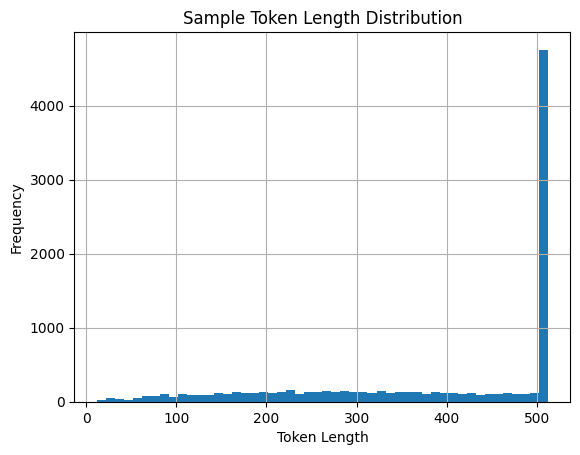

In [13]:
import matplotlib.pyplot as plt

# 3.1 先计算每个样本的 token 长度
lengths = [len(ids) for ids in tokenized_ds["input_ids"]]

# 3.2 绘制直方图
plt.figure()
plt.hist(lengths, bins=50)
plt.title("Sample Token Length Distribution")
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


/tmp/ipykernel_1481/3060879890.py:22: UserWarning: Glyph 65292 (\N{FULLWIDTH COMMA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1481/3060879890.py:22: UserWarning: Glyph 12290 (\N{IDEOGRAPHIC FULL STOP}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1481/3060879890.py:22: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1481/3060879890.py:22: UserWarning: Glyph 12289 (\N{IDEOGRAPHIC COMMA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1481/3060879890.py:22: UserWarning: Glyph 22312 (\N{CJK UNIFIED IDEOGRAPH-5728}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1481/3060879890.py:22: UserWarning: Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1481/3060879890.py:22: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1481/30608798

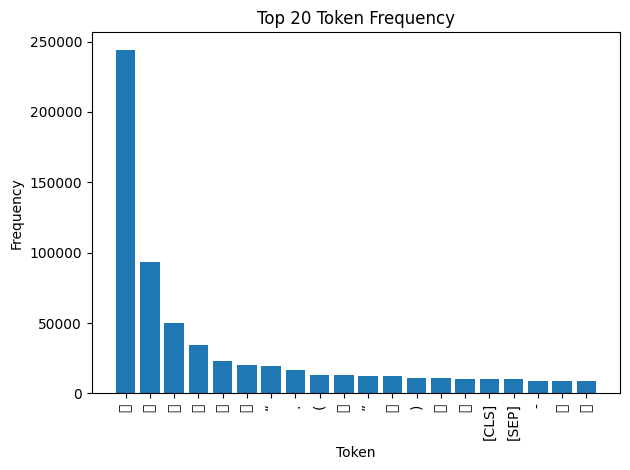

In [14]:
from collections import Counter

# 4.1 展平所有 input_ids
all_ids = [i for ids in tokenized_ds["input_ids"] for i in ids]

# 4.2 统计出现频次
counter = Counter(all_ids)
top20 = counter.most_common(20)

tokens, freqs = zip(*[
    (tokenizer.convert_ids_to_tokens(tok_id), freq)
    for tok_id, freq in top20
])

# 4.3 绘制柱状图
plt.figure()
plt.bar(range(len(tokens)), freqs)
plt.xticks(range(len(tokens)), tokens, rotation=90)
plt.title("Top 20 Token Frequency")
plt.xlabel("Token")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()
